In [1]:
from dm_control import composer
import numpy as np
from pole_composer import BalancePoleOnTop, Pole
from tensordict.tensordict import TensorDict
import torch

In [2]:
random_state = np.random.RandomState(2)
env = composer.Environment(BalancePoleOnTop(Pole()), random_state=random_state)

In [3]:
timestep = env.reset()

In [4]:
timestep

TimeStep(step_type=<StepType.FIRST: 0>, reward=None, discount=None, observation=OrderedDict([('unnamed_model/joint_pos', array([[0.00551454]])), ('unnamed_model/joint_velocity', array([[0.]])), ('unnamed_model/tip_pos', array([0.   , 0.   , 0.008]))]))

In [5]:
env.action_spec()

BoundedArray(shape=(1,), dtype=dtype('float64'), name='unnamed_model/pole_actuator', minimum=[-2.5], maximum=[2.5])

In [6]:
env.observation_spec()

OrderedDict([('unnamed_model/joint_pos',
              Array(shape=(1, 1), dtype=dtype('float64'), name='unnamed_model/joint_pos')),
             ('unnamed_model/joint_velocity',
              Array(shape=(1, 1), dtype=dtype('float64'), name='unnamed_model/joint_velocity')),
             ('unnamed_model/tip_pos',
              Array(shape=(3,), dtype=dtype('float64'), name='unnamed_model/tip_pos'))])

In [7]:
# TODO: Stacked observations?

In [8]:
timestep.observation

OrderedDict([('unnamed_model/joint_pos', array([[0.00551454]])),
             ('unnamed_model/joint_velocity', array([[0.]])),
             ('unnamed_model/tip_pos', array([0.   , 0.   , 0.008]))])

In [9]:
for k, v in timestep.observation.items():
    print(v.shape, k)

(1, 1) unnamed_model/joint_pos
(1, 1) unnamed_model/joint_velocity
(3,) unnamed_model/tip_pos


In [10]:
obs = {
    'joint_pos': timestep.observation['unnamed_model/joint_pos'],
    'joint_velocity': timestep.observation['unnamed_model/joint_velocity'],
}
obs = TensorDict(obs, batch_size=[1, 1])[0]
obs

TensorDict(
    fields={
        joint_pos: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float64, is_shared=False),
        joint_velocity: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float64, is_shared=False)},
    batch_size=torch.Size([1]),
    device=None,
    is_shared=False)

In [11]:
spec = env.action_spec()
action = random_state.uniform(spec.minimum, spec.maximum, spec.shape)
print(action)
timestep = env.step(action)
timestep

[-1.82710027]


TimeStep(step_type=<StepType.MID: 1>, reward=0.0, discount=1.0, observation=OrderedDict([('unnamed_model/joint_pos', array([[-0.06851996]])), ('unnamed_model/joint_velocity', array([[-2.05474992]])), ('unnamed_model/tip_pos', array([0.00401169, 0.        , 0.20006904]))]))

In [12]:
from gymnasium.wrappers import FrameStack, TimeLimit, RecordEpisodeStatistics
from gymnasium.utils.env_checker import check_env
from gymnasium import Env, spaces, ActionWrapper
from gymnasium.vector import SyncVectorEnv


class BalancePoleEnv(Env):
    reward_range = (0, 1.0)
    max_episode_steps = 64
    # spec: EnvSpec | None = None

    def __init__(self):
        self.env = composer.Environment(BalancePoleOnTop(Pole()))
        self.timestep = None

    @property
    def action_space(self):
        return spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
    
    @property
    def observation_space(self):
        return spaces.Box(low=-float("inf"), high=float("inf"), shape=(2,), dtype=np.float32)

    def step(self, action):
        action = action * 2.1  # Denormalize from [-1, 1] to [-2.1, 2.1]
        self.timestep = self.env.step(action)
        return self.observe(), self.timestep.reward, False, False, {}

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.timestep = self.env.reset()
        return self.observe(), {}
    
    def observe(self):
        return torch.from_numpy(np.array([
            self.timestep.observation['unnamed_model/joint_pos'], 
            self.timestep.observation['unnamed_model/joint_velocity'],
        ])).squeeze()

    def render(self):
        return self.env.physics.render()


check_env(BalancePoleEnv())

vec_env = SyncVectorEnv([BalancePoleEnv] * 2)
vec_env = FrameStack(vec_env, 3)
vec_env = TimeLimit(vec_env, 100)
vec_env = RecordEpisodeStatistics(vec_env, deque_size=100)

/opt/homebrew/Caskroom/miniforge/base/envs/rl/lib/python3.9/site-packages/gymnasium/envs/registration.py:845: UserWarning: WARN: Overriding environment GymV26Environment-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/opt/homebrew/Caskroom/miniforge/base/envs/rl/lib/python3.9/site-packages/gymnasium/utils/env_checker.py:221: UserWarning: WARN: A Box observation space minimum value is -infinity. This is probably too low.
  logger.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/rl/lib/python3.9/site-packages/gymnasium/utils/env_checker.py:225: UserWarning: WARN: A Box observation space maximum value is -infinity. This is probably too high.
  logger.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/rl/lib/python3.9/site-packages/gymnasium/spaces/box.py:230: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")
/opt/homebrew/Caskroom/miniforge/base/envs/rl/lib/python3.9/site-packages/gymn

In [13]:
vec_env.reset()

(<gymnasium.wrappers.frame_stack.LazyFrames at 0x29ae562c0>, {})

In [14]:
vec_env.action_space, vec_env.action_space.sample()

(Box(-1.0, 1.0, (2, 1), float32),
 array([[0.2426391 ],
        [0.15752654]], dtype=float32))

In [15]:
env = BalancePoleEnv()
env.reset()
for i in range(10):
    action = env.action_space.sample()
    _, reward, _, _, _ = env.step(action)
    print(action, reward)

[0.68607426] 0.0
[-0.99672157] 0.0
[0.88876534] 0.0
[-0.83971626] 0.0
[-0.2663493] 0.0
[0.90412664] 0.0
[0.88334554] 0.0
[0.67232704] 0.0
[-0.09105109] 0.0
[0.38507637] 0.0


# RL Algo! DDPG

In [16]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cpu")

In [18]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

In [19]:
"""
Ornstein-Uhlenbeck process
Adding time-correlated noise to the actions taken by the deterministic policy
wiki (https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process)
https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py
"""
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)
    

In [20]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

In [21]:
class ValueNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(ValueNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
    

class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(PolicyNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, num_actions)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = F.tanh(self.linear3(x))
        return x
    
    def get_action(self, state):
        state  = torch.tensor(state).unsqueeze(0).float().to(device)
        action = self.forward(state)
        return action.detach().cpu().numpy()[0, 0]

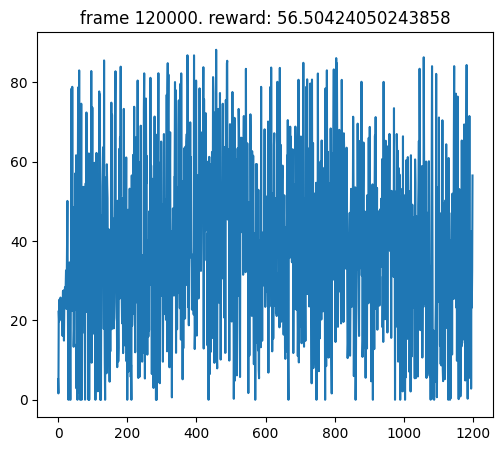

In [23]:
def ddpg_update(batch_size, 
           gamma = 0.99,
           min_value=-np.inf,
           max_value=np.inf,
           soft_tau=1e-2):
    
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    
    state      = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

    policy_loss = value_net(state, policy_net(state))
    policy_loss = -policy_loss.mean()

    next_action    = target_policy_net(next_state)
    target_value   = target_value_net(next_state, next_action.detach())
    expected_value = reward + (1.0 - done) * gamma * target_value
    expected_value = torch.clamp(expected_value, min_value, max_value)

    value = value_net(state, action)
    value_loss = value_criterion(value, expected_value.detach())


    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()

    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()

    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

    for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )


env = BalancePoleEnv()
env = TimeLimit(env, 100)
ou_noise = OUNoise(env.action_space)

state_dim  = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
hidden_dim = 512

value_net  = ValueNetwork(state_dim, action_dim, hidden_dim).to(device)
policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

target_value_net  = ValueNetwork(state_dim, action_dim, hidden_dim).to(device)
target_policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)

for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
    target_param.data.copy_(param.data)
    
    
value_lr  = 1e-3
policy_lr = 1e-4

value_optimizer  = optim.Adam(value_net.parameters(),  lr=value_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)

value_criterion = nn.MSELoss()

replay_buffer_size = 1000000
replay_buffer = ReplayBuffer(replay_buffer_size)

max_frames  = 120000
max_steps   = 150
frame_idx   = 0
rewards     = []
batch_size  = 128

while frame_idx < max_frames:
    state, _ = env.reset()
    ou_noise.reset()
    episode_reward = 0
    
    for step in range(max_steps):
        action = policy_net.get_action(state)
        action = ou_noise.get_action(action, step)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        replay_buffer.push(state, action, reward, next_state, done)
        if len(replay_buffer) > batch_size:
            ddpg_update(batch_size)
        
        state = next_state
        episode_reward += reward
        frame_idx += 1
        
        if frame_idx % max(1000, max_steps + 1) == 0:
            plot(frame_idx, rewards)
        
        if done:
            break
    
    rewards.append(episode_reward)

Look at one video

/var/folders/qz/8lxmcg3s6ls7rqr51bjgj4080000gp/T/ipykernel_40385/306138059.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state  = torch.tensor(state).unsqueeze(0).float().to(device)
/opt/homebrew/Caskroom/miniforge/base/envs/rl/lib/python3.9/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Text(0.5, 0, 'time')

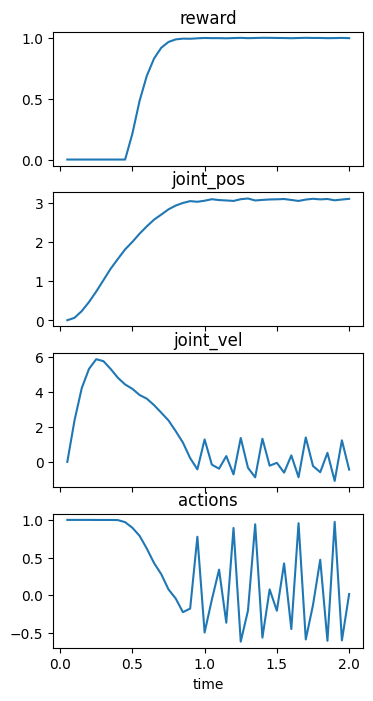

In [30]:
from matplotlib.animation import ArtistAnimation
from matplotlib import cm

# Simulate episode with random actions
duration = 2  # Seconds
framerate = 30
frames = []
ticks = []
rewards = []
observations = []
joint_positions = []
joint_velocities = []
actions = []
fig = plt.figure()

state, _ = env.reset()
physics = env.unwrapped.env.physics
while physics.data.time < duration:
    action = policy_net.get_action(state)
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    
    frames.append([plt.imshow(physics.render(), cmap=cm.Greys_r, animated=True)])
    rewards.append(reward)
    ticks.append(physics.data.time)
    joint_positions.append(state[0])
    joint_velocities.append(state[1])
    actions.append(action)
    
    state = next_state
    if done:
        break

ArtistAnimation(fig, frames, interval=1000 / framerate, blit=True, repeat_delay=1000).save("pole_trained.mp4")
plt.close()

_, ax = plt.subplots(4, 1, sharex=True, figsize=(4, 8))
ax[0].plot(ticks, rewards)
ax[0].set_title("reward")

ax[1].plot(ticks, joint_positions)
ax[1].set_title("joint_pos")

ax[2].plot(ticks, joint_velocities)
ax[2].set_title("joint_vel")

ax[3].plot(ticks, actions)
ax[3].set_title("actions")

ax[-1].set_xlabel("time")
